# Departamento médico

### Primeiramente vamos importar as bibliotecas necessárias


In [1]:
import os
import cv2 #OpenCV
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
xray_directory = '/content/drive/My Drive/Departamento médico/Dataset'

In [4]:
os.listdir(xray_directory)

['.DS_Store', '2', '3', '1', '0']

In [5]:
image_generator = ImageDataGenerator(rescale = 1./255)

In [6]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = xray_directory,
                                                     shuffle = True, target_size=(256,256),
                                                     class_mode = 'categorical',
                                                     subset='training')

Found 532 images belonging to 4 classes.


In [7]:
train_images, train_labels = next(train_generator)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [9]:
train_labels.shape

(40, 4)

In [10]:
# COVID-19   - 1 0 0 0
# Saudável   - 0 1 0 0 
# Viral      - 0 0 1 0
# Bacteriana - 0 0 0 1

labels_names = {0: 'COVID-19', 
                1: 'Saudável', 
                2: 'Pneumonia viral', 
                3: 'Pneumonia bacteriana'}

## Visualização dos dados

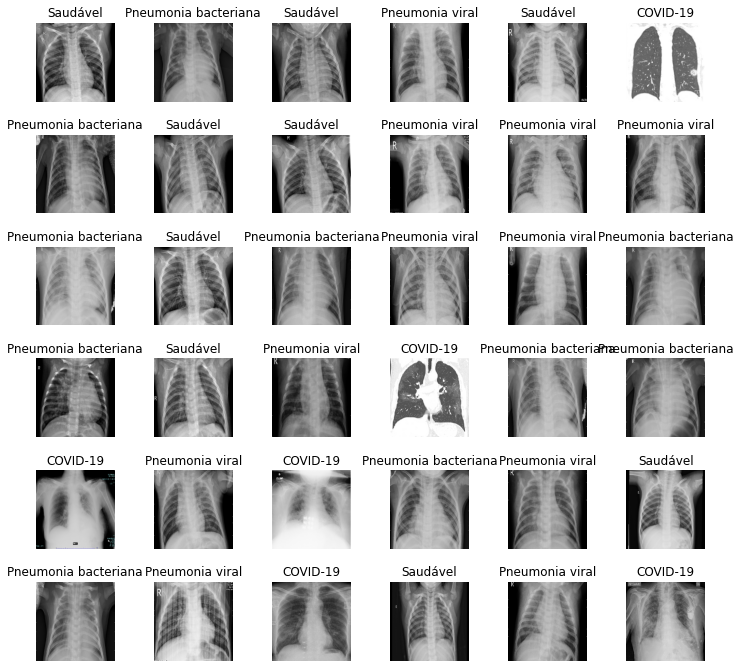

In [11]:
fig, axs = plt.subplots(6, 6, figsize = (12,12))
axs = axs.ravel()
for i in np.arange(0, 36):
    axs[i].imshow(train_images[i])
    axs[i].set_title(labels_names[np.argmax(train_labels[i])])
    axs[i].axis('off')
    
plt.subplots_adjust(wspace=0.5)

## Carregamento da rede neural com pesos pré-treinados

### Como o treinamento completo do modelo pode demorar um tempo considerável, iremos aqui importar um modelo já pronto, treinado para um problema de classificação semelhante. Depois iremos retreinar as camadas finais para que ele possa se adaptar ao nosso problema.

In [12]:
base_model = ResNet50(weights='imagenet', include_top=False,
                     input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 4s 0us/step


In [13]:
for layers in base_model.layers[:-10]:
  layers.trainable = False

### Aqui acima nós bloqueamos os pesos de treino de todas as camadas até antes das dez últimas, a intenção é permitir que apenas as dez últimas possam ser treinadas para que o modelo se adapte as imagens do banco de dados.

## Construção e treinamento do modelo 

### Aqui será inserido novas camadas após a última do modelo pré-carregado.

In [18]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.1)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.1)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [19]:
model = Model(inputs = base_model.input, outputs = head_model)

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

### Uma vez que este modelo leva um tempo considerável para ser treinado, iremos, a cada passo, salvar os pesos obtidos.

In [21]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5') #, save_best_only = True)

In [22]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [26]:
history = model.fit_generator(train_generator, epochs = 25, callbacks = [checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/25
133/133 [==============================] - 231s 2s/step - loss: 1.2404 - accuracy: 0.4586
Epoch 2/25
133/133 [==============================] - 182s 1s/step - loss: 0.9997 - accuracy: 0.5695
Epoch 3/25
133/133 [==============================] - 180s 1s/step - loss: 0.8219 - accuracy: 0.6748
Epoch 4/25
133/133 [==============================] - 172s 1s/step - loss: 0.7445 - accuracy: 0.7218
Epoch 5/25
133/133 [==============================] - 178s 1s/step - loss: 0.6338 - accuracy: 0.7613
Epoch 6/25
133/133 [==============================] - 175s 1s/step - loss: 0.6081 - accuracy: 0.7726
Epoch 7/25
133/133 [==============================] - 173s 1s/step - loss: 0.6423 - accuracy: 0.7575
Epoch 8/25
133/133 [==============================] - 178s 1s/step - loss: 0.5347 - accuracy: 0.8233
Epoch 9/25
133/133 [==============================] - 173s 1s/step - loss: 0.5045 - accuracy: 0.8045
Epoch 10/25
133/133 [==============================] - 174s 1s/step - loss: 0.4777 - accura

## Avaliação da rede neural

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

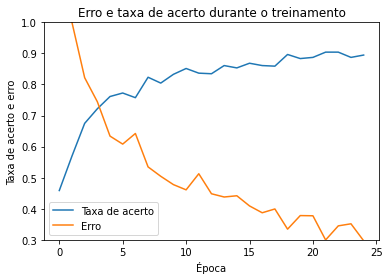

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.ylim(0.3,1)
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

In [29]:
test_directory = '/content/drive/My Drive/Departamento médico/Test'

In [30]:
os.listdir(test_directory)

['3', '2', '0', '1']

In [31]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [32]:
evaluate = model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


### Utilizando os dados de teste o modelo apresentou uma performance de 70% de acerto, um valor razoável para as poucas épocas que foram utilizadas.

In [33]:
evaluate 

[1.3798530101776123, 0.699999988079071]

In [34]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 296ms/step


In [35]:
print(prediction)

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 3, 2, 2, 1, 0, 0, 2, 3, 3, 1, 3, 1]


In [36]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [38]:
accuracy_score(original, prediction)

0.675

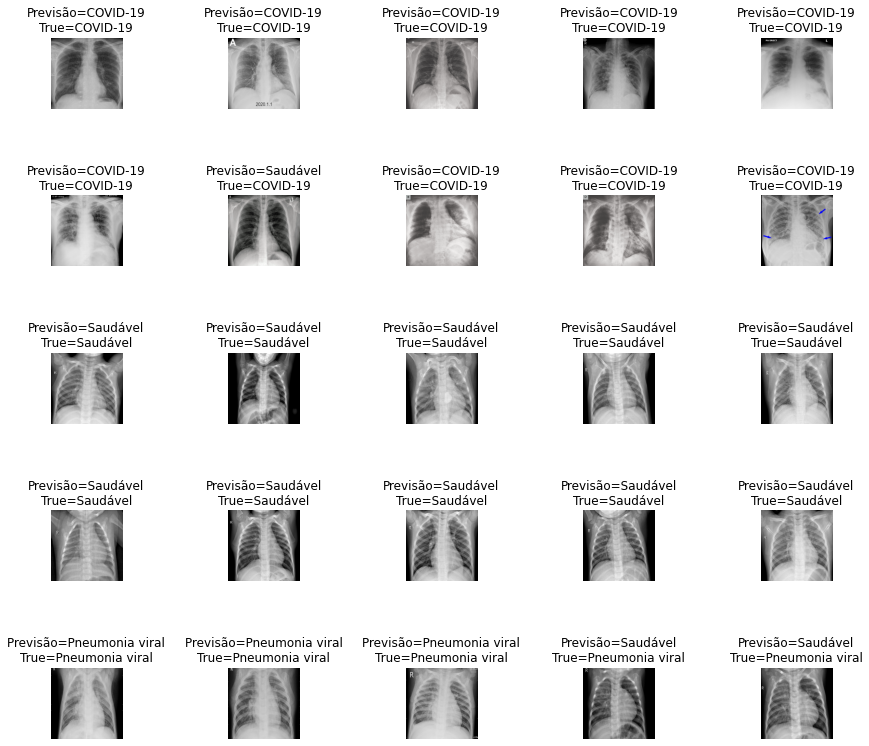

In [39]:
fig, axes = plt.subplots(5, 5, figsize=(14,14))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.5)

In [40]:
labels_names

{0: 'COVID-19', 1: 'Saudável', 2: 'Pneumonia viral', 3: 'Pneumonia bacteriana'}

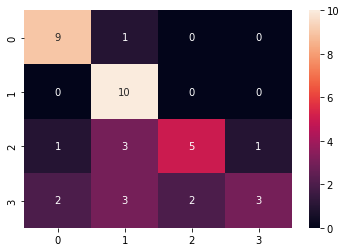

In [41]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [42]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.59      1.00      0.74        10
           2       0.71      0.50      0.59        10
           3       0.75      0.30      0.43        10

    accuracy                           0.68        40
   macro avg       0.70      0.67      0.64        40
weighted avg       0.70      0.68      0.64        40



## Utilizando o modelo salvo

### Aqui iremos ler os pesos salvos a partir do modelo treinado anteriormente, para utilizar o modelo.

In [43]:
from keras.models import load_model
model_loaded = load_model('/content/weights.hdf5')

In [44]:
img = cv2.imread('/content/drive/My Drive/Departamento médico/Test/0/radiol.2020200490.fig3.jpeg')

In [45]:
img, img.shape

(array([[[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        [[192, 192, 192],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [134, 134, 134]],
 
        ...,
 
        [[196, 196, 196],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  3,   3,   3],
         [134, 134, 134]],
 
        [[187, 187, 187],
         [  5,   5,   5],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  7,   7,   7],
         [129, 129, 129]],
 
        [[214, 214, 214],
         [ 80,  80,  80],
         [ 87,  87,  87],
         ...,
         [ 80,  80,  80],
  

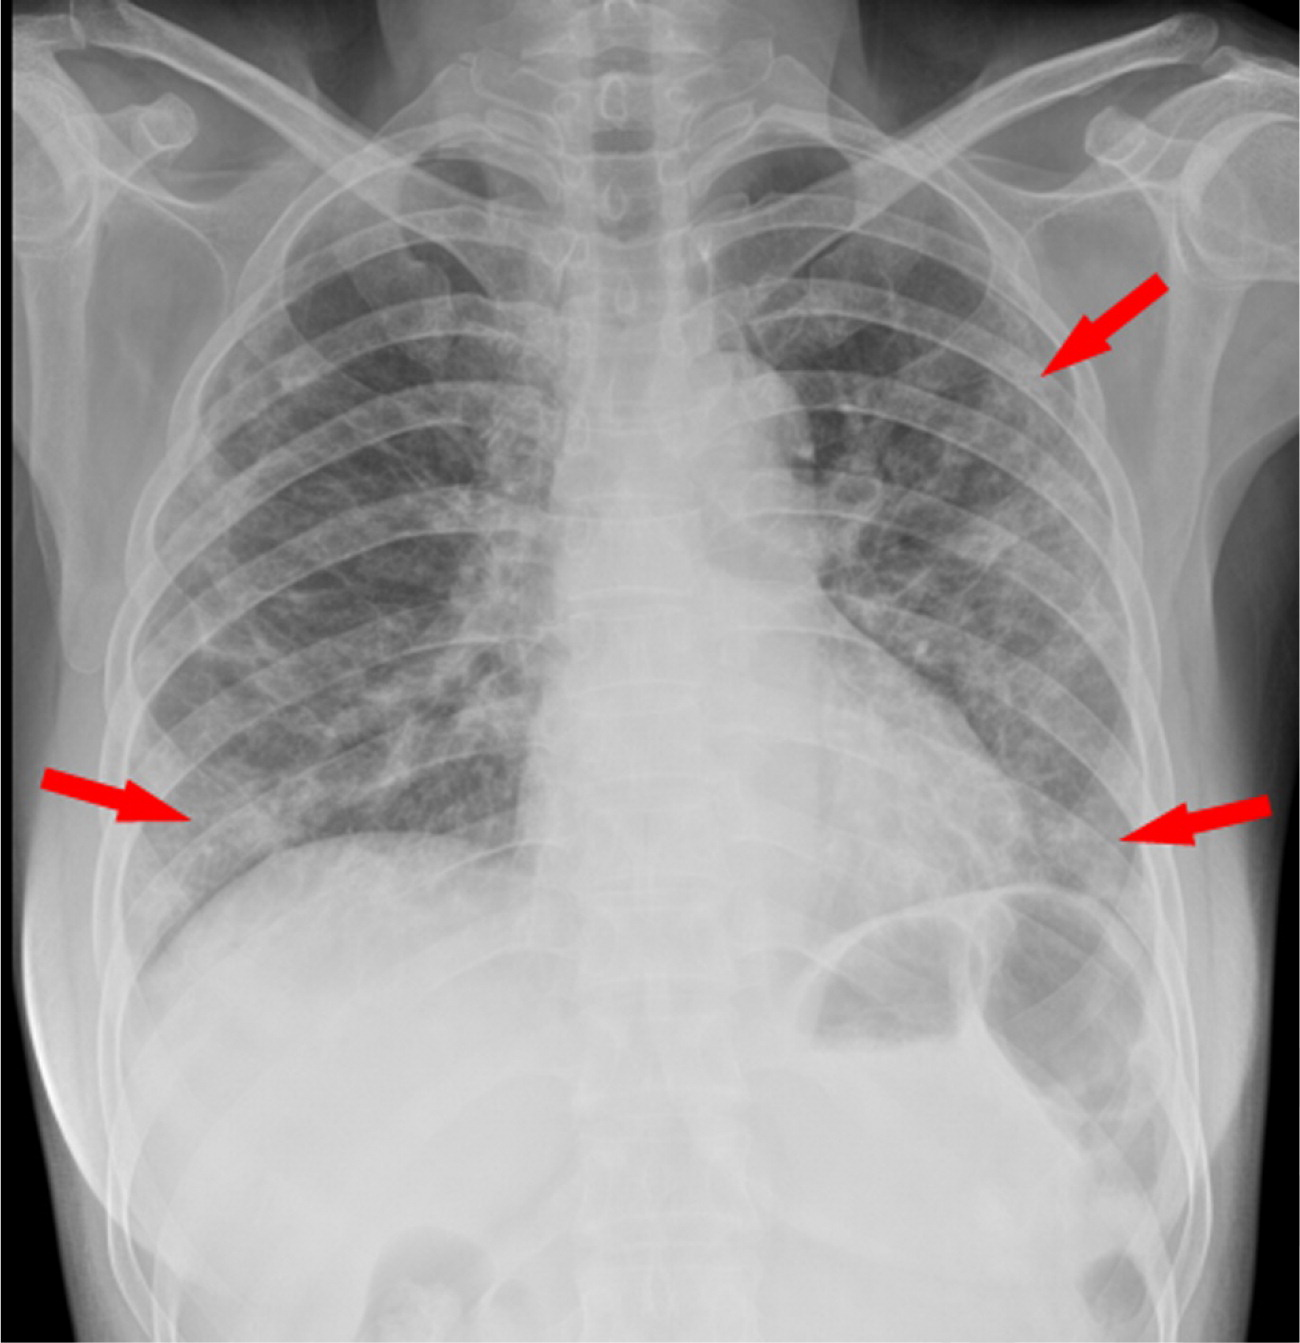

In [46]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

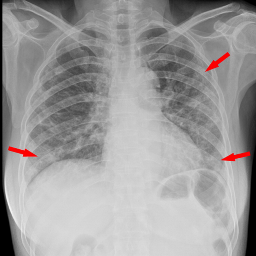

In [47]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [48]:
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.10980392, 0.10980392, 0.10980392],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.12941176, 0.12941176, 0.12941176],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16470588, 0.16470588, 0.16470588],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [49]:
img.shape


(256, 256, 3)

In [50]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [55]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[9.9999917e-01, 1.5740109e-07, 6.2214161e-07, 1.5303996e-07]],
      dtype=float32)>

In [52]:
predict2 = np.argmax(predict)
predict2

0

In [54]:
labels_names[predict2], predict[0][predict2]

('COVID-19', <tf.Tensor: shape=(), dtype=float32, numpy=0.99999917>)